clip encoder의 text prompt를 특정한 한국어 단어로 체계적으로 분류해 image embedding과 dot product 시키고 학습진행

![아키텍쳐.jpg](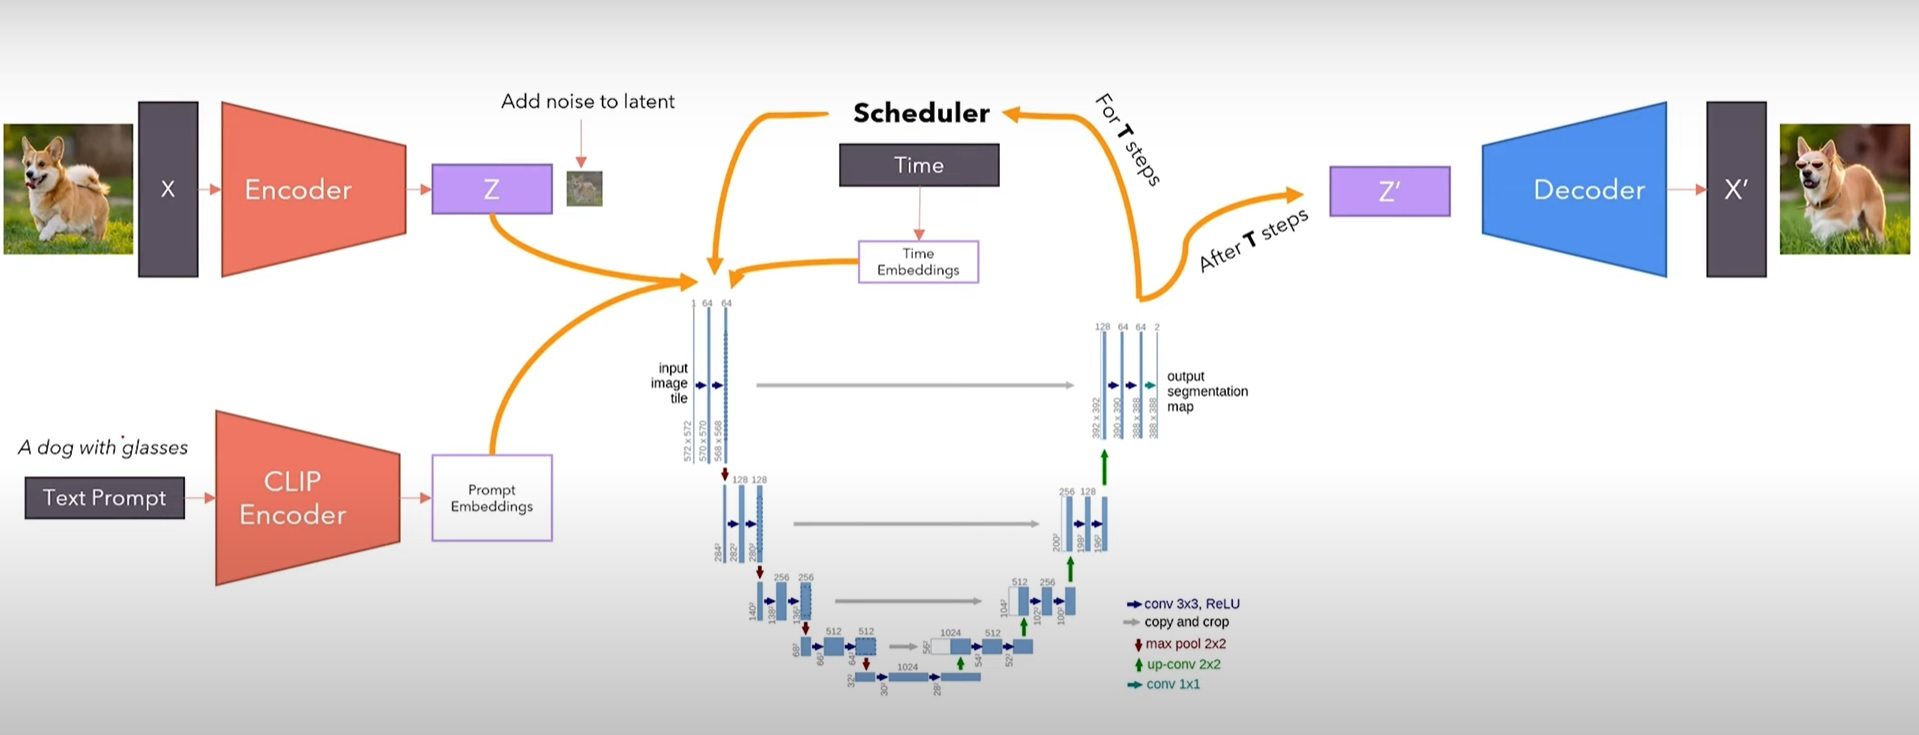![selfattention.png](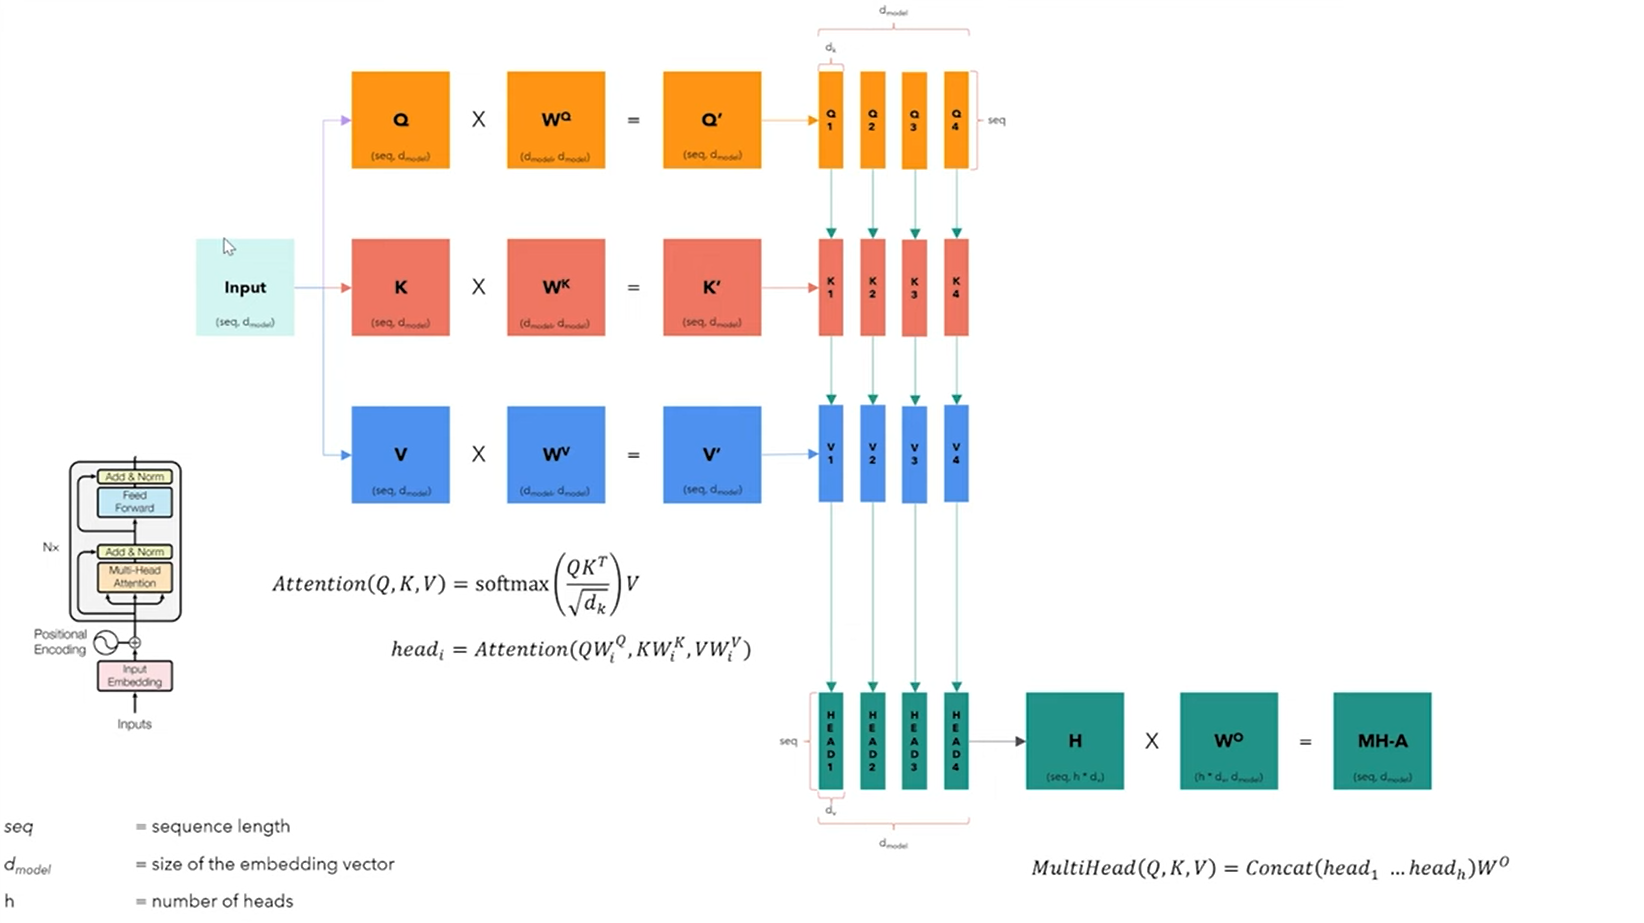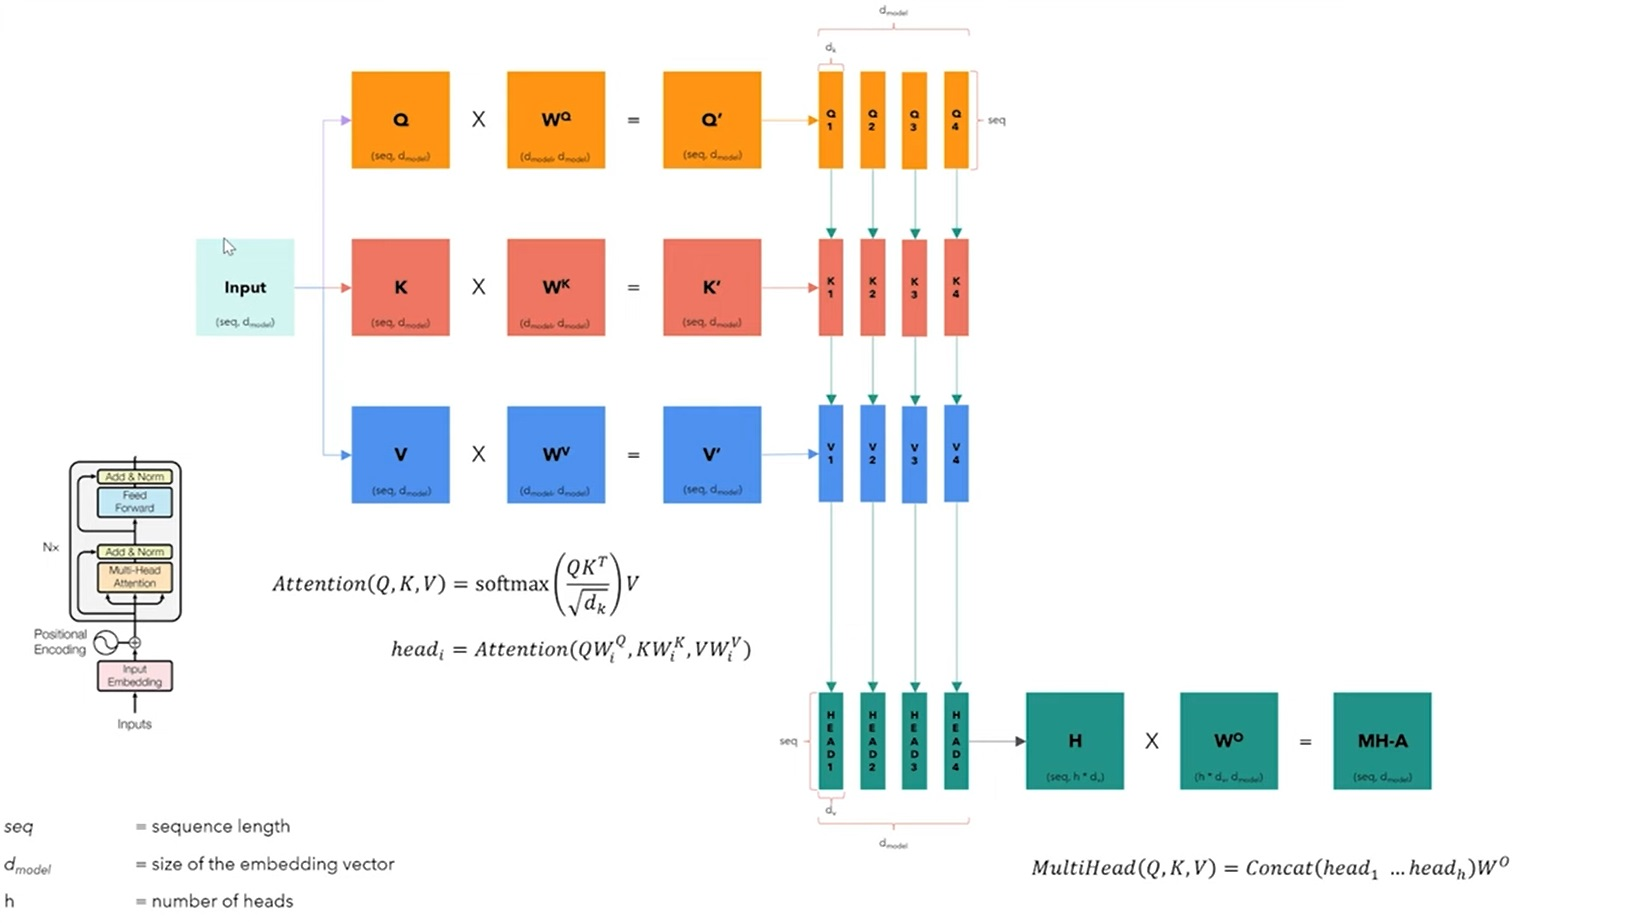))

In [ ]:
# %%writefile encoder.py
import torch
from torch import nn
from torch.nn import functional as f
from decoder import VAEattentionblock, VAEresidualblock
class VAEencoder(nn.Sequential):
  def __init__(self):
    super.__init__(

        # bs,c,h,w => bs,128,h,w
        nn.Conv2d(3,128,kernel_size=3,padding=1),
        VAEresidualblock(128,128),
        VAEresidualblock(128,128),

        # bs,128,h,w => bs,128,h/2,w/2 채널수가 변하지않아서 h,w가 1/2배됨
        nn.Conv2d(128,128,kernel_size=3,stride=2),
        VAEresidualblock(128,256),
        VAEresidualblock(256,256),

        #bs,256,h/2,w/2 > bs,256,h/4,w/4
        nn.Conv2d(256,256,kernel_size=3,stride=2),  #nn.conv2d padding 기본값은 0
        VAEresidualblock(256,512),
        VAEresidualblock(512,512),

        VAEattentionblock(512),
        VAEresidualblock(512,512),

        nn.GroupNorm(32,512),
        nn.SiLU(),

        nn.Conv2d(512,8,kernel_size=3,padding=1),
        nn.Conv2d(8,8,kernel_size=1), #커널사이즈 1 shape 변화 없음


        #bs,256,h/4,w/4 > bs,256,h/8,w/8
        nn.Conv2d(512,512,kernel_size=3,stride=2),
        VAEresidualblock(256,512),
        VAEresidualblock(512,512),
        VAEresidualblock(512,512),
    )
  def forward(self, x : torch.Tensor, noise : torch.Tensor) -> torch.Tensor:
    # x : bs, c, h,w
    # noise : bs, out_channels, h/8,w/8
    for module in self: # 상속받은 layers
      if getattr(module,'stride',None) == (2,2):  #stride 옆으로 2칸, 밑으로 2칸씩 이동
        # padding (좌,우,상,하)
        f.pad(x,(0,1,0,1))
      x= module(x)

  #다변량 정규분포의 mean variance, latent space
    # (bs,8,h/8,w/8) -> (bs,4,h/8,w/8)
    mean , log_var = torch.chunk(x,2,dim=1)

    # -30,20 사이의 값으로 clamp
    log_var = torch.clamp(log_var,-30,20)

    var = log_var.exp()
    #std
    std = var.sqrt()

    # Z = N(0,1) -> N(mean,variance)
    mean + std * noise

    #scale output
    x *= 0.18125 #경험론적 방법에 의해 얻어진 scale 상수

    return x

Writing encoder.py


In [ ]:
# %%writefile decoder.py

import torch
from torch import nn
from torch.nn import functional as f
from attention import selfattention

class VAEattentionblock(nn.Module):

  def __init__(self,channels : int):
    super().__init__()
    self.groupnorm = nn.GroupNorm(32,channels)
    self.attention = selfattention(1,channels)

  def __call__(self,x: torch.Tensor) -> torch.Tensor:

    residue = x

    batchsize,c,h,w = x.shape

    x =  x.view(batchsize,c,h*w)

    # bs,features,h*w -> bs,h*w,features h*w 는 sequence, sequence마다 각각의 features를 가지고 있음
    # -> selfattention 으로 sequence간의 관련성
    x = x.transpose(-1,-2)

    x = self.attention(x)

    x = x.transpose(-1,-2)

    x = x.view((batchsize,c,h,w))

    x += residue

    return x

class VAEresidualblock(nn.Module):

  def __init__(self,inchannels,outchannels):
    super().__init__()
    self.groupnorm1 = nn.GroupNorm(32,inchannels)
    self.conv1 = nn.Conv2d(inchannels,outchannels,kernel_size=3,padding=1)
    self.groupnorm2 = nn.GroupNorm(32,outchannels)
    self.conv2 = nn.Conv2d(outchannels,outchannels,kernel_size=3,padding=1)

    if inchannels == outchannels:
      self.residual_layer = nn.Identity()
    else: # inchannel outchannel 맞춰주기 위함
      self.residual_layer = nn.Conv2d(inchannels,outchannels,kernel_size=1)

  def forward(self,x:torch.Tensor) -> torch.Tensor:

    # x = batchsize,inchannels,height,width
    residue = x

    x = self.groupnorm1(x)

    x = f.silu(x)

    x = self.conv1(x)

    x = self.groupnorm2(x)

    x = f.silu(x)

    x = self.conv2(x)

    return x + self.residual_layer(residue)
    #inchannel outchannel 같으면 nn.identity <- 아무 변화 없음
    #다른경우 conv2d layer

class VAEdecoder(nn.Sequential):
  def __init__(self):
    super().__init__(
      nn.Conv2d(4,4,kernel_size=1),

      nn.Conv2d(4,512,kernel_size=3,padding=1),

      VAEresidualblock(512,512),

      VAEattentionblock(512),

      VAEresidualblock(512,512),
      VAEresidualblock(512,512),
      VAEresidualblock(512,512),
      VAEresidualblock(512,512),

      #batchsize,512,height/8,width/8 -> batchsize,512,height/4,width/4
      nn.Upsample(scale_factor=2),
      # 가로 세로 크기 2배로 늘림
      # 기본으로 nearest 방식을 사용, 가장 빠르지만 이미지 품질이 저하될수있음
      nn.Conv2d(512,512,kernel_size=3,padding=1),

      VAEresidualblock(512,512),
      VAEresidualblock(512,512),
      VAEresidualblock(512,512),
      #batchsize,512,h/4,w/4 -> batchsize,512,h/2,w/2
      nn.Upsample(scale_factor=2),

      nn.Conv2d(512,512,kernel_size=3,padding=1),

      VAEresidualblock(512,256),
      VAEresidualblock(256,256),
      VAEresidualblock(256,256),

      #batchsize,512,h/2,w/2 -> batchsize,512,h,w
      nn.Upsample(scale_factor=2),

      nn.Conv2d(256,256,kernel_size=3,padding=1),

      VAEresidualblock(256,128),
      VAEresidualblock(128,128),
      VAEresidualblock(128,128),

      nn.Groupnorm(32,128),

      f.silu(),

      #batchsize,128,height,width -> batchsize,3,height,width
      nn.Conv2d(128,3,kernel_size=3,padding=1)
    )

  def __call__(self,x : torch.Tensor) -> torch.Tensor:
    # batchsize, 4, h/8, w/8
    x/= 0.18215
    for module in self:
      x = module(x)

    # batchsize, 3, h, w
    return x


Overwriting decoder.py


In [ ]:
# %%writefile attention.py
import torch
from torch import nn
from torch.nn import functional as f
import math
class selfattention(nn.Module):
                          # embd= embedding_dim
  def __init__(self,numheads,embd,in_bias=True,out_bias=True):
    super().__init__()

    #weight matrix 과정
    self.in_linear = nn.Linear(embd,embd*3,bias=in_bias)
    self.out_linear = nn.Linear(embd,embd,bias= out_bias)

    self.numheads = numheads
    self.headdim = embd / numheads

  def __call__(self,x:torch.Tensor,causal_mask =False):
    # x = batchsize, sequence_length, embeddingdim
    inputshape = x.shape
    batchsize,seqlen, embd = inputshape

    intermin_shape =(batchsize,seqlen,self.numheads,self.headdim)
    q,k,v = self.in_linear(x).chunk(3,dim=-1) #dim = -1 embeddingdim을 3개로 나눔

    #배치 사이즈, 시퀸스 길이, 임베딩 디멘션 ->
    #배치 사이즈, 시퀸스 길이, 헤드 개수, 헤드 디멘션 ->
    #배치 사이즈, 해드 개수, 시퀸스 길이, 헤드 디멘션
    q = q.view(intermin_shape).transpose(1,2)
    k = k.view(intermin_shape).transpose(1,2)
    v = v.view(intermin_shape).transpose(1,2)

          # seqlen,headdim @ headdim,seqlen
          #-> seqlen,seqlen
    weight = q @ k.transpose(-1,-2)

    if causal_mask:
      mask = torch.ones_like(weight,dtype=torch.bool).triu(1)
      #triu u = up tril l = low
      #triu 상부 삼각부분 반환 대각선 밑의 부분은 0
      weight.masked_fill(mask,-torch.inf)

    #denominator self attention의 /root(d|k) 부분
    weight /= math.sqrt(self.headdim)

    weight = f.softmax(weight,dim=-1)
    # (batchsize,numheads, seqlen,seqlen) @ (batchsize, numheads, seqlen, headim)
    #-> bs,numheads,seqlen,headdim
    output = weight @ v

    #->bs,seqlen,numheads,headdim
    output = output.transpose(1,2)

    # ->batchsize,seqlen,embeddingdim
    output = output.reshape(inputshape)

    output = self.out_linear(output)

    return output

Writing attention.py


In [ ]:
# %%writefile clip.py
import torch
from torch import nn
from torch.nn import functional as f
from attention import selfattention

class CLIPembedding(nn.Module):
                 #49408,768,77
  def __init__(self, nvocab : int, embd : int, ntokens : int):
    super().__init__()

    self.tokenembedding = nn.embedding(nvocab,embd)
    self.positionembedding = nn.Parameter(torch.zeros(ntokens,embd))

  def __call__(self,tokens):
    x = self.tokenembedding(tokens)
    x += self.positionembedding
    return x

class CLIPlayer(nn.Module):
  def __init__(self,numheads,embd):
    super().__init__()
    self.layernorm1 = nn.LayerNorm(embd)
    self.attention = selfattetion(numheads,embd)
    self.layernorm2 = nn.LayerNorm(embd)
    self.linear1 = nn.Linear(embd,4*embd)
    self.linear2 = nn.Linear(4*embd,embd)

  def forward(self,x:torch.Tensor) -> torch.Tensor:
    # bs, seqlen, dim
    residue = x

    x = self.layernorm1(x)
    x = self.attention(x,causal_mask=True) #단어의 지나간 부분 안봄
    x += residue

    ##feedforward layer

    x = residue

    x = self.layernorm2(x)

    x = self.linear(x)

    x = x * torch.sigmoid(1.702 * x) #gelu function

    x = self.linear2(x)

    x += residue

    return x
class CLIP(nn.Module):

  def __init__(self):
    self.embedding = CLIPembedding(49408,768,77)

    self.layers == nn.Module([
        CLIPlayer(12,768) for i in range(12)
    ])

    self.layernorm = nn.LayerNorm(768)

  def __call__(self,token: torch.LongTensor)-> torch.FloatTensor:
    tokens = tokens.type(torch.long)

    #batchsize, seqlen -> batchsize, seqlen, dim
    #state = 현재 text data의 tokenembedding, positonalembedding 한 것
    state = self.embedding(tokens)

    for layer in self.layers:
      state = layer(state)

    #batchsize,seqlen,dim
    output = self.layernorm(state)

    return output

In [2]:
# %%writefile diffusion using unet
import torch
from torch import nn
from torch.nn import functional as f
from attention import selfattention,crossattention



#더욱 정교한 이미지 제어: 시간 정보를 통해 모델은 이미지 생성 과정의 각 단계에서 어떤 특징을 강조할지 결정
#더욱 안정적인 이미지 생성: 시간 정보를 통해 모델은 이미지 생성 과정을 더욱 안정적으로 수행
#더욱 빠른 이미지 생성: 시간 정보를 통해 모델은 이미지 생성 과정을 더욱 빠르게 수행

class TimeEmbedding(nn.Module):
  def __init__(self,embd):
    super().__init__()
    self.linear1 = nn.Linear(embd,4*embd)
    self.linear2 = nn.Linear(4*embd,4*embd)

  def forward(self,x:torch.Tensor):
    # x :(1,320)
    x = self.linear1(x)
    x = f.silu(x)
    x = self.linear2(x)
    # 1,1280
    return x

class switchsequential(nn.Sequential):
                    #x = latent
  def forward(self, x,context,time) -> torch.Tensor:
    for layer in self:
      # switchsequential이라는 클래스를 정의하고 이를 nn.Sequential에서 상속받
      # switchsequential instance self는 nn.Sequential
      if isinstance(layer,UNETattentionblock):
        x= layer(x,context)
      elif isinstance(layer,UNETresidualblock):
        x = layer(x,time)
      else:
        x = layer(x)
    return x



class UNETresidualblock(nn.Module):
  pass

class UNETattentionblock(nn.Module):
  pass

class Upsample(nn.Module): #nn.Upsampling의
  def __init__(self,channels):
    super().__init__()
    self.conv = nn.Conv2d(channels,channels,kernel_size=3,padding=1)

  def __call__(self,x): #h,w 2배
    x = f.interpolate(x,scale_factor = 2,mode='nearest')
    return self.conv(x)

class UNEToutputlayer(nn.Module):
  def __init__(self,inchannels,outchannels):
    super().__init__():
    self.groupnorm = nn.GroupNorm(32,inchannels)
    self.conv = nn.Conv2d(inchannels,outchannels,kernel_size=3,padding=1)

  def __call__(self,x):
    # x = batchsize,320,h/8,w/8 unet의 마지막 xshape
    x = self.groupnorm(x)

    x = f.silu(x)

    x = self.conv(x)

    #bs, 4, h/8, w/8
    return x



class UNET(nn.Module): #기본적으로 encoder - bottleneck - decoder구조 그 중간의 skip connection

  def __init__(self):
    super().__init__()
    self.encoder = nn.Module([
        #batchsize 4 h/8 w/8

        switchsequential(nn.Conv2d(4,320,kernel_size=3,padding=1)),

        switchsequential(UNETresidualblock(320,320),UNETattentionblock(8,40)),

        switchsequential(UNETresidualblock(320,320),UNETattentionblock(8,40)),

        #batchsize 320 h/16 w/16
        switchsequential(nn.Conv2d(320,320,kernel_size=2,padding=1)),

        switchsequential(UNETresidualblock(320,640),UNETattentionblock(8,80)),

        switchsequential(UNETresidualblock(320,640),UNETattentionblock(8,80)),

        #batchsize 640 h/32 w/32

        switchsequential(nn.Conv2d(640,640,kernel_size=3,stride=2,padding=1)),

        switchsequential(UNETresidualblock(640,1280),UNETattentionblock(8,160)),

        switchsequential(UNETresidualblock(1280,1280),UNETattentionblock(8,160)),

        #batchsize 1280 h/64 w/64

        switchsequential(nn.Conv2d(1280,1280,kernel_size=3,stride=2,padding=1)),

        switchsequential(UNETresidualblock(1280,1280)),
        #batchsize 1280 h/64 w/64

        switchsequential(UNETresidualblock(1280,1280)),
    ])

    self.bottleneck = switchsequential(
        UNETresidualblock(1280,1280),
        UNETattentionblock(8,160),
        UNETresidualblock(1280,1280),
    )

    self.decoder = nn.Modulelist([

    #bs,2560,h/64,w/64 2560인 이유 skip connection에 의해서 residue가 더해짐
    #bs,1260,h/64,w/64
      switchsequential(UNETresidualblock(2560,1280)),
      switchsequential(UNETresidualblock(2560,1280)),
      switchsequential(UNETresidualblock(2560,1280),Upsample(1280)),
      switchsequential(UNETresidualblock(2560,1280),UNETattentionblock(8,160)),
      switchsequential(UNETresidualblock(2560,1280),UNETattentionblock(8,160)),
      switchsequential(UNETresidualblock(1920,1280),UNETattentionblock(8,160),Upasample(1280)),
      switchsequential(UNETresidualblock(1920,640),UNETattentionblock(8,80)),
      switchsequential(UNETresidualblock(1280,640),UNETattentionblock(8,80)),
      switchsequential(UNETresidualblock(960,640),UNETattentionblock(8,80),Upsample(640)),
      switchsequential(UNETresidualblock(960,320),UNETattentionblock(8,40)),
      switchsequential(UNETresidualblock(640,320),UNETattentionblock(8,40)), #80
      switchsequential(UNETresidualblock(640,320),UNETattentionblock(8,40)),

    ])


class diffusion(nn.Module):

  def __init__(self):
    self.timeembedding = TimeEmbedding(320)
    self.unet = UNET()
    self.final = UNEToutputlayer(320,4)

  def forward(self,latent : torch.Tensor, context: torch.Tensor, time: torch.Tensor):
    # latent - batchsize, 4 ,h/8, w/8
    # - encoder 결과물
    # - 이미지의 multivariational gaussian 분포
    # - 잠재벡터

    # context - batchsize,seqlen,dim - CLIP 결과물
    # time - (1,320)
    time = self.timeembedding

    #batchsize, 4, h/8, w/8 -> batchsize, 320, h/8, w/8
    output = self.unet(latent,context,time)

    output = self.final(output)

    return output















ModuleNotFoundError: No module named 'attention'

In [ ]:
#